In [5]:
import sys
sys.path.append('../..')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator 
from qiskit.utils import QuantumInstance
from qubap.qiskit.luciano.costfunc_barren_plateaus import global2local, test_hamiltonian 
from qubap.qiskit.luciano.variational_algorithms import VQE, energy_evaluation, classical_solver
from qubap.qiskit.jorge.tools import SPSA_calibrated, make_list_and_callback

In [7]:
num_qubits = 8
hamiltonian_global = test_hamiltonian( num_qubits, [1,2,3] )
hamiltonian_global

PauliSumOp(SparsePauliOp(['XXXXXXXX', 'YYYYYYYY', 'ZZZZZZZZ'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j]), coeff=1.0)

In [8]:
classical_solution = classical_solver( hamiltonian_global ).eigenvalue
classical_solution

-4.000000000000004

In [9]:
hamiltonian_local = global2local( hamiltonian_global )
hamiltonian_local

PauliSumOp(SparsePauliOp(['IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII', 'IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j, 0.25 +0.j, 0.25 +0.j, 0.25 +0.j, 0.25 +0.j,
 0.25 +0.j, 0.25 +0.j, 0.25 +0.j, 0.25 +0.j, 0.375+0.j, 0.375+0.j,
 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j]), coeff=1.0)

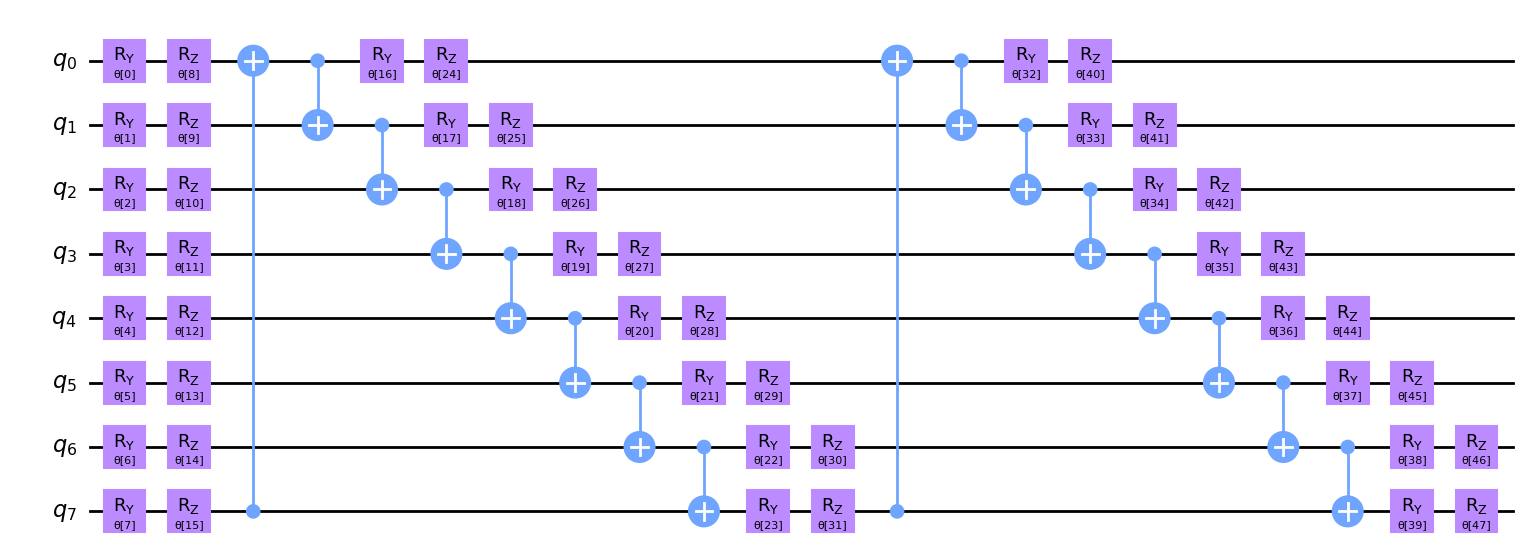

In [10]:
reps   = 2
ansatz = EfficientSU2( num_qubits, ['ry','rz'], 'circular', reps ).decompose()
ansatz.draw('mpl') 

In [11]:
npars = 2*num_qubits*( reps + 1 )
pars  = np.random.randn( npars ) * np.pi
quantum_instance = QuantumInstance( AerSimulator() , shots = 2**4 )

In [12]:
energy_evaluation( hamiltonian_global, ansatz, pars, quantum_instance )

-5.551115123125783e-17

In [13]:
num_iters = 300

In [14]:
results_global = VQE( hamiltonian_global, ansatz, pars, num_iters, quantum_instance )
data_global    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_global ]

In [15]:
results_global[0].shape

(48,)

In [17]:
data_global    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_global ]

In [19]:
results_local = VQE( hamiltonian_local, ansatz, pars, num_iters//3, quantum_instance ) 
data_local    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') )  for x in results_local ]

In [23]:
results_global_after_local = VQE( hamiltonian_global, ansatz, results_local[-1], 
                                    2*num_iters//3, quantum_instance, iter_start=num_iters//3 ) 
data_global_after_local    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) 
                                    for x in results_global_after_local ]  

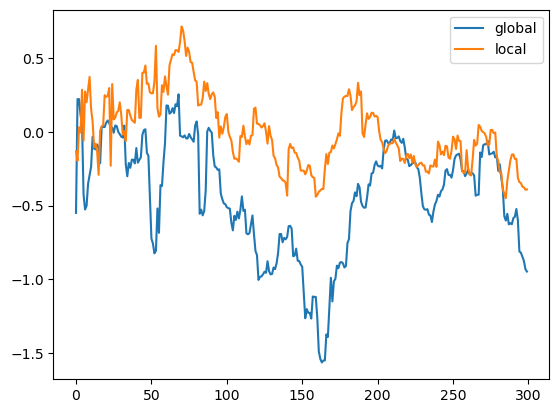

In [24]:
plt.plot( data_global )
plt.plot( np.append(data_local,data_global_after_local) )
# plt.hlines( classical_solution, 0, num_iters, 'r' )
plt.legend(['global','local'])